In [1]:
import numpy as np
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import time
import multiprocessing
import os
from copy import deepcopy
import numpy.ma as ma

In [2]:
%run ../methodsMemoryDeposition

In [3]:
%run ../main.py

Stopped at time: 100.00161102010382| N_Ptcls: 36071| N_snapshots: 101


In [208]:
params = {
    "height":              1000,
    "dom":                 1000,
    "ndim":                   1,
    "t_max":               1000,
    "r_0":                    2,
    "tau":                   1,
    "dt_snapshot":            1,       
    "n_ptcl_snapshot":    np.inf,
    "foldername":  "SimResults",
}

In [209]:
r = params["r_0"]
tau = params["tau"]
params["filename"] = f"result_r0_{r:.1e}&tau_{tau:.1e}"
_ = main1D_w_plotting(params)

Fully Occupied at time: 266.592710362693| N_Ptcls: 429031| N_snapshots: 267


In [6]:
max_height_time, times = main(params)

EVERYONE IS DEAD AT: 1662.313591108558 | N_Ptcls: 136131| N_snapshots: 167


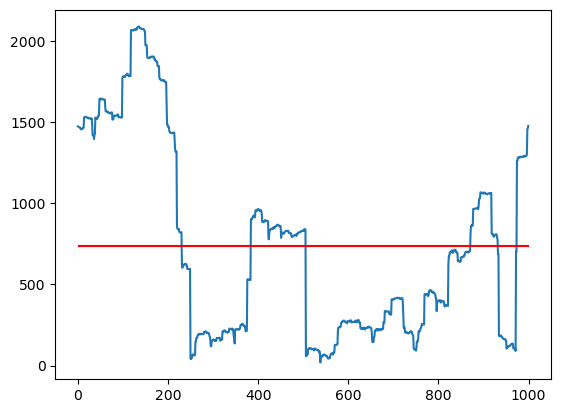

In [18]:
plt.figure()
plt.plot(max_height_time[-1])
plt.hlines(np.mean(max_height_time[-1]), 0, 1000, colors='r')
plt.show()

In [5]:
height = max_height_time[-1]
above_normal = (height >= np.mean(height))

In [4]:
def get_fingers(max_height):
    height = max_height
    above_normal = (height >= np.mean(height))
    
    means = []
    sizes = []
    current_size = 0
    current_mean = 0
    current_location = 0

    for site in above_normal:

        if site:
            current_size += 1
            current_mean += current_location
        
        if not site:
            if current_size != 0:
                sizes.append(current_size)
                means.append(current_mean)
            current_size = 0
            current_mean = 0
        
        current_location += 1

    else:
        if current_size != 0:
            if above_normal[0] == above_normal[-1]:
                means[0] += current_size*params["dom"] - current_mean
                sizes[0] += current_size
            else:
                sizes.append(current_size)
                means.append(current_mean)

    means = np.array(means)/np.array(sizes)
    return means, sizes



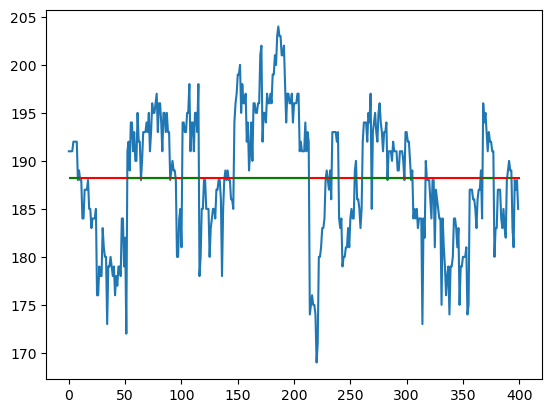

In [8]:
plt.figure()
plt.plot(max_height_time[-1])

mean_line = np.mean(max_height_time[-1])
means, sizes = get_fingers(max_height_time[-1])

plt.hlines(mean_line, 0, params["dom"], colors='r')

for size, mean in zip(sizes, means):
    low_bound = mean-size/2
    high_bound = mean+size/2

    if low_bound <= 0:
        plt.hlines(mean_line, params["dom"]-low_bound, params["dom"], colors="g")
        low_bound = 0
    plt.hlines(mean_line, low_bound, high_bound, colors='g')
plt.show()

In [10]:
params = {
    "height":             10000,
    "dom":                 1000,
    "ndim":                   1,
    "t_max":               1000,
    "r_0":                    1,
    "tau":                    1,
    "dt_snapshot":            1,       
    "n_ptcl_snapshot":    np.inf,
    "foldername":  "SimResults",
    "filename": "shit",
}

In [207]:
def main_Finger(params):
    width = params["dom"]
    d = 1
    params["max_CDF"] = cutoff = max_CDF(params)
    t = n_ptcls = n_snapshot = 0 
    max_height_time = []
    finger_means = []
    finger_sizes = []
    times = []

    shape = tuple(width for _ in range(d))
    max_height = np.zeros((width), dtype=int) #occupation/height at each site
    t_next = np.array([single_time(0, params) for _ in range(width)])

    while(t<params["t_max"]):
        index_chosen = np.argmin(t_next)
        t_min = t_next[index_chosen]

        if t_min == np.inf:
            print(f"EVERYONE IS DEAD AT: {t} | N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")

        max_height = add_point_ndarray(index_chosen, max_height, shape)

        neighbors = get_nearest_non_diagonal_neighbors(index_chosen, shape)
        for index_ngbh in neighbors:
            t_next[index_ngbh] = single_time(t_min, params)
        t_next[index_chosen] = single_time(t_min, params)

        t = t_min

        if (
            t > n_snapshot*params["dt_snapshot"]
            ) or (
                n_ptcls%params["n_ptcl_snapshot"] == 0
                ):
                max_height_time.append(max_height)
                means, sizes = get_fingers(max_height)
                finger_means.append(means)
                finger_sizes.append(sizes)
                times.append(t)

                n_snapshot += 1
        n_ptcls += 1

    mean_sizes_time = [np.mean(sizes) for sizes in finger_sizes]
    std_sizes_time = [np.std(sizes) for sizes in finger_sizes]
    mean_num_time = [len(sizes) for sizes in finger_sizes]
    y_low = np.array(mean_sizes_time) - np.array(std_sizes_time)
    y_high = np.array(mean_sizes_time) + np.array(std_sizes_time)

    return times, mean_sizes_time, (y_low, y_high), mean_num_time

In [ ]:
num_repeats = 5

for r0 in [0.94,1, 1.04]:
    params["r0"] = r0
    for _ in range(num_repeats):
        times, mean_sizes_time, low_high, mean_num_time = main_Finger(params)
        y_low, y_high = low_high

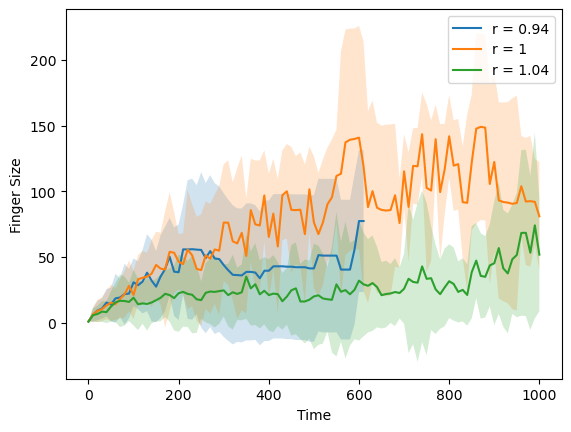

In [203]:

plt.plot(times0, mean_sizes_time0, label=label0)
plt.fill_between(times0, y_low0, y_high0, alpha=0.2)

plt.plot(times1, mean_sizes_time1, label=label1)
plt.fill_between(times1, y_low1, y_high1, alpha=0.2)

plt.plot(times2, mean_sizes_time2, label=label2)
plt.fill_between(times2, y_low2, y_high2, alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Finger Size")
plt.legend()

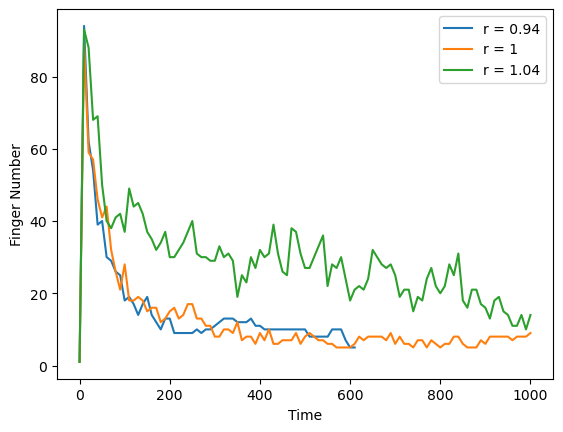

In [206]:
plt.plot(times0, std_num_time0, label=label0)
# plt.fill_between(times0, y_low0, y_high0, alpha=0.2)

plt.plot(times1, std_num_time1, label=label1)
# plt.fill_between(times1, y_low1, y_high1, alpha=0.2)

plt.plot(times2, mean_num_time2, label=label2)
# plt.fill_between(times2, y_low2, y_high2, alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Finger Number")
plt.legend()